In [51]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [3]:
df = pd.read_csv("./data/aggregate_data.csv")

In [11]:
# Create sequences
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    indices = []
    for i in range(len(data) - sequence_length):
        sequence = data[i : i + sequence_length]
        # print(sequence)
        target = data[i + sequence_length]
        sequences.append(sequence)
        targets.append(target)
        indices.append(i)
    return np.array(sequences), np.array(targets), np.array(indices)

In [12]:
# Define sequence length
sequence_length = 5

# Create sequences for each ID
sequences = []
targets = []
all_indices = []
for id, group in df.groupby('experimenter'):
    id_sequences, id_targets, id_indices = create_sequences(group['stress_level'].values, sequence_length)
    sequences.append(id_sequences)
    targets.append(id_targets)
    all_indices.append(group.index[id_indices])
    
X = np.vstack(sequences)
y = np.hstack(targets)
indices = np.hstack(all_indices)
# scaler = StandardScaler()
# scaler = scaler.fit(X)
# X = scaler.transform(X)

In [13]:
def train_test_split_by_experimenter(X, y, data: pd.DataFrame, experimenter_name: str):
    """
    Splits the features and target into training and testing sets based on the experimenter.
    
    Parameters:
    X (pd.DataFrame or np.ndarray): The feature DataFrame or array.
    y (pd.Series or np.ndarray): The target Series or array.
    data (pd.DataFrame): The input DataFrame containing a column named 'experimenter'.
    experimenter_name (str): The name of the experimenter to filter by.
    
    Returns:
    pd.DataFrame or np.ndarray, pd.DataFrame or np.ndarray, pd.Series or np.ndarray, pd.Series or np.ndarray:
    X_train, X_test, y_train, y_test
    """
    # Check if the 'experimenter' column exists in the DataFrame
    if 'experimenter' not in data.columns:
        raise ValueError("The input DataFrame must contain a column named 'experimenter'.")
    
    # Identify the indices for the specified experimenter and the others
    experimenter_indices = data[data['experimenter'] == experimenter_name].index
    test_indices = np.where(np.isin(indices, experimenter_indices))[0]
    train_indices = np.where(~np.isin(indices, experimenter_indices))[0]
    
    # Split the features and target into training and testing sets
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = train_test_split_by_experimenter(X, y, df, 'Kiara')

In [15]:
X_train

array([[2, 3, 3, 3, 3],
       [3, 3, 3, 3, 2],
       [3, 3, 3, 2, 1],
       ...,
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2]])

In [41]:
# Define the RNN model
model = Sequential([
    LSTM(units=128, input_shape=(sequence_length, 1), activation='relu') #return_sequences=True)
])
model.add(Dropout(0.2))
model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())

# model.add(LSTM(64, activation='relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))
# Compile the model
# cp = ModelCheckpoint('model/.keras', save_best_only=True)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,332 (278.64 KB)

 Trainable params: 71,076 (277.64 KB)

 Non-trainable params: 256 (1.00 KB)

In [43]:
# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2838 - loss: 1.4161 - val_accuracy: 0.6328 - val_loss: 1.2652
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5061 - loss: 1.1340 - val_accuracy: 0.6540 - val_loss: 1.0550
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5693 - loss: 1.0113 - val_accuracy: 0.6730 - val_loss: 0.8508
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6004 - loss: 0.9804 - val_accuracy: 0.7402 - val_loss: 0.7524
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6233 - loss: 0.9350 - val_accuracy: 0.7418 - val_loss: 0.7224
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6057 - loss: 0.9528 - val_accuracy: 0.7561 - val_loss: 0.7043
Epoch 7/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6278 - loss: 0.9319 - val_accuracy: 0.7683 - val_loss: 0.6975
Epoch 8/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6383 - loss: 0.9228 - val_accuracy: 0.

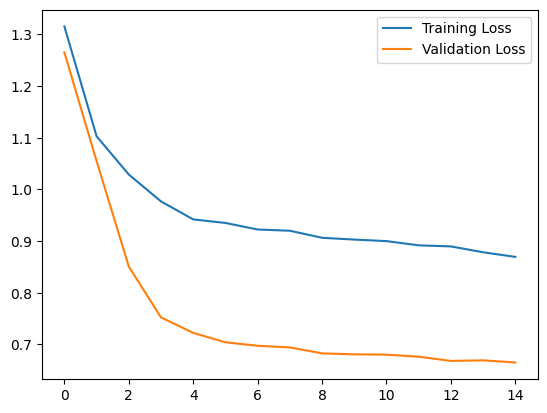

In [44]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()

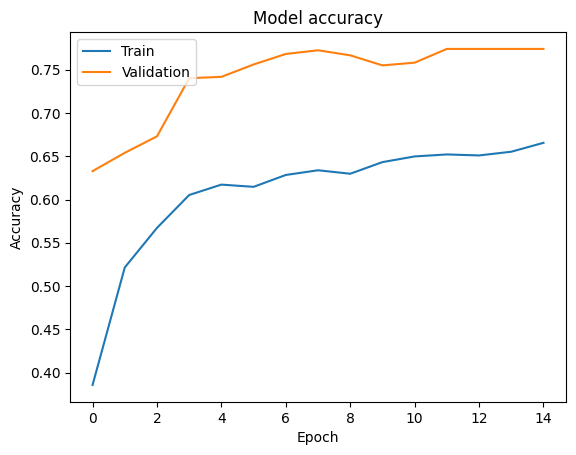

In [46]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [48]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) 

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [50]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr', average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

Accuracy: 0.774074074074074
Precision: 0.7726750517145623
Recall: 0.774074074074074
F1 Score: 0.7729442758144485
ROC-AUC: 0.9042699887541397


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step


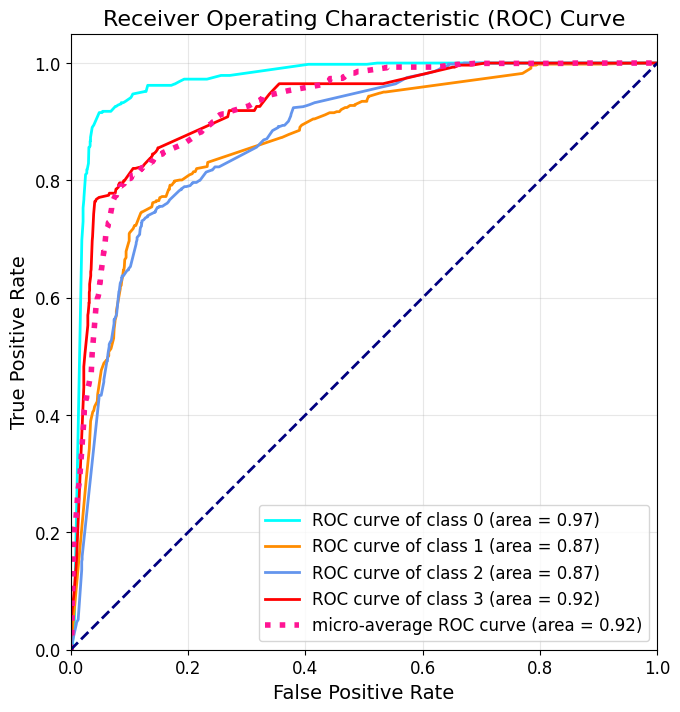

In [54]:
y_pred_probs = model.predict(X_test)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))
    
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()